In [1]:
from IPython.display import display, HTML

display(HTML('''
<style>
.container { 
    width:95% !important; 
}
</style>
'''))

# Problem

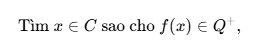

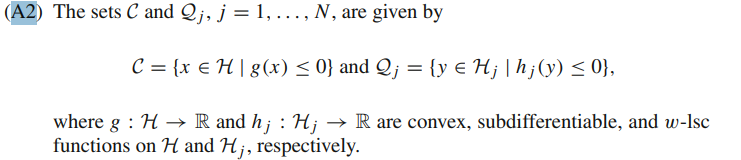

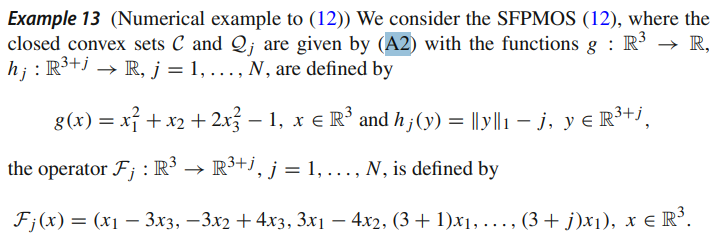

# Implement

In [2]:
from scipy.optimize import Bounds
from autograd import grad
import autograd.numpy as np  
from autograd import jacobian
from project import Projection
from algorithm_CQ import CQ_split_acceptance
from problem import Problem

## Config

In [3]:
def f(x):
    return np.array([
        x[0] - 3*x[2], 
        -3*x[1] + 4*x[2], 
        3*x[0] - 4*x[1], 
        4*x[0]
    ])

#--------------- C --------------------#
def c1(x):
    return x[0]**2 + x[1] + 2*x[2]**2 - 1 

#--------------- Q --------------------#
def q1(y):
    j = 1
    return np.linalg.norm(y, 1) - j

def q1_dx(y):
    return np.sign(y)

def q_plus_val(z):
    positive_sum = np.sum(np.maximum(0, z))
    return np.array([1.0 - positive_sum])

In [4]:
c1_dx = grad(c1)
# q1_dx = grad(q1)

In [5]:
def q_plus_jac(z):

    grad = np.where(z > 0, -1.0, 0.0)
    return np.array([grad])

In [6]:
cons_C = (
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([-c1(x)]),     
#         'jac' : lambda x: np.array([-c1_dx(x)])   
    },
)


bounds_x = None
dim_x = 3

In [7]:
cons_Q = (
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([-q1(x)]),     
#         'jac' : lambda x: np.array([-q1_dx(x)])   
    },
)

bounds_f = None
dim_y = 4

In [8]:
cons_Qplus = (
    {
        'type': 'ineq',
        'fun' : lambda x: np.array([q_plus_val(x)]),
        'jac' : lambda x: np.array([q_plus_jac(x)])
    },
)

In [9]:
class Problem():
    def __init__(self, f, jac_f, C, Q, dim_x, dim_y, proj_C, proj_Qplus):
        self.f = f
        self.jac_f = jac_f
        self.C = C
        self.Q = Q
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        vals = [func(x) for func in self.f]
        return np.concatenate(vals)
    
    def jacobian(self, x):
        jacs = [func(x) for func in self.jac_f]
        return np.vstack(jacs)

In [10]:
proj_C = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')

proj_Qplus = Projection(cons=cons_Q, bounds=bounds_f, dim=dim_y, proj_type='qplus')

prob = Problem(
    f=[f],
    jac_f=[jacobian(f)],
    C=[c1],
    Q=[q1],
    dim_x=dim_x,
    dim_y=dim_y,
    proj_C=proj_C.project,
    proj_Qplus=proj_Qplus.project
    
)

In [11]:
x0 = np.random.rand(1,dim_x).tolist()
# x0 = [[1.0, 2.0, 3.0]]

## Run

In [12]:
x_opt, x_hist, f_hist, z_proj_hist = CQ_split_acceptance(
                                f=prob.objective_func,
                                jac_f=prob.jacobian,
                                proj_C=prob.proj_C,
                                proj_Qplus=prob.proj_Qplus,
                                x0=x0,
                                gamma=0.01,
                                max_iter=100,
                                tol=1e-6
                            )

Khởi tạo: x0: [[0.5973254568361034, 0.2059155447301968, 0.3269663813236847]]
Chiếu lên C được: x: [0.5974 0.206  0.3269]


 62%|██████▏   | 62/100 [00:00<00:00, 95.01it/s] 


Hội tụ tại vòng lặp 62
+----+--------------------------------+----------------------------------------------+----------------------------------------------+----------+----------+
| k  | x_new                          | y                                            | z_proj                                       |   e_x    |   e_f    |
+----+--------------------------------+----------------------------------------------+----------------------------------------------+----------+----------+
| 0  | [0.512744, 0.265393, 0.299335] | [-0.38341 ,  0.689796,  0.968228,  2.38948 ] | [-0.38341,  0.     ,  0.     ,  1.     ]     | 0.107023 | 1.828644 |
| 1  | [0.456403, 0.296495, 0.283285] | [-0.385261,  0.40116 ,  0.476658,  2.050976] | [-0.385261,  0.      ,  0.      ,  1.      ] | 0.066326 | 1.221754 |
| 2  | [0.417905, 0.311095, 0.273473] | [-0.393453,  0.243658,  0.183231,  1.825612] | [-0.393453, -0.      ,  0.      ,  1.      ] | 0.042327 | 0.880101 |
| 3  | [0.390759, 0.316287, 0.267048] | 

# Viz

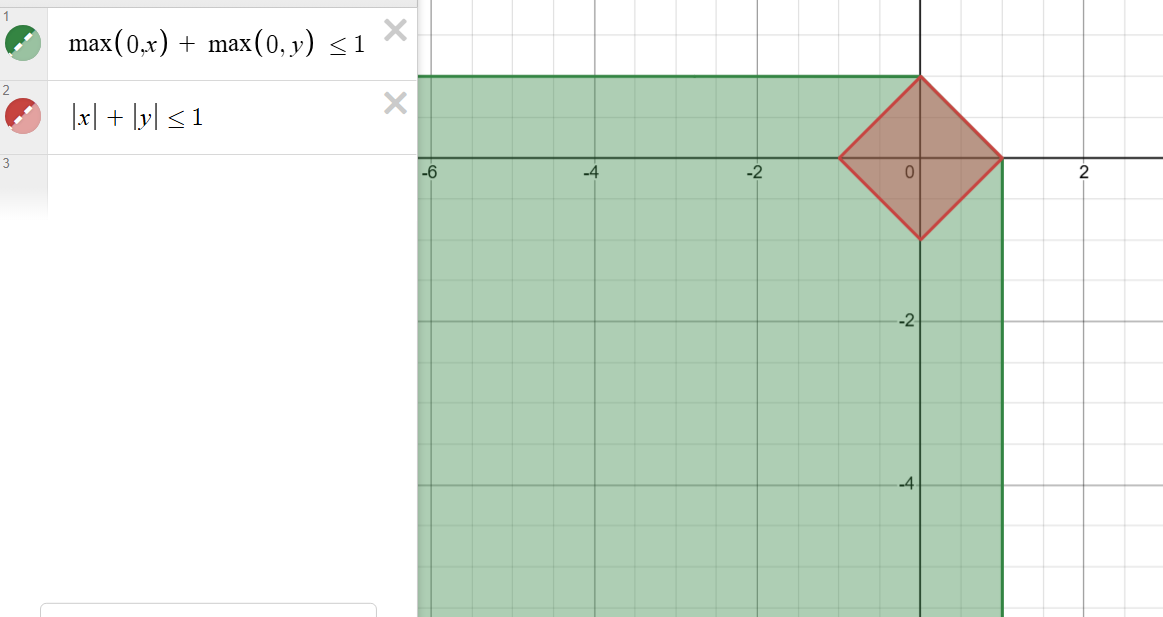

In [13]:
from utils import visualize_complete_system

Đang xử lý dữ liệu và tạo đồ thị tổng hợp...


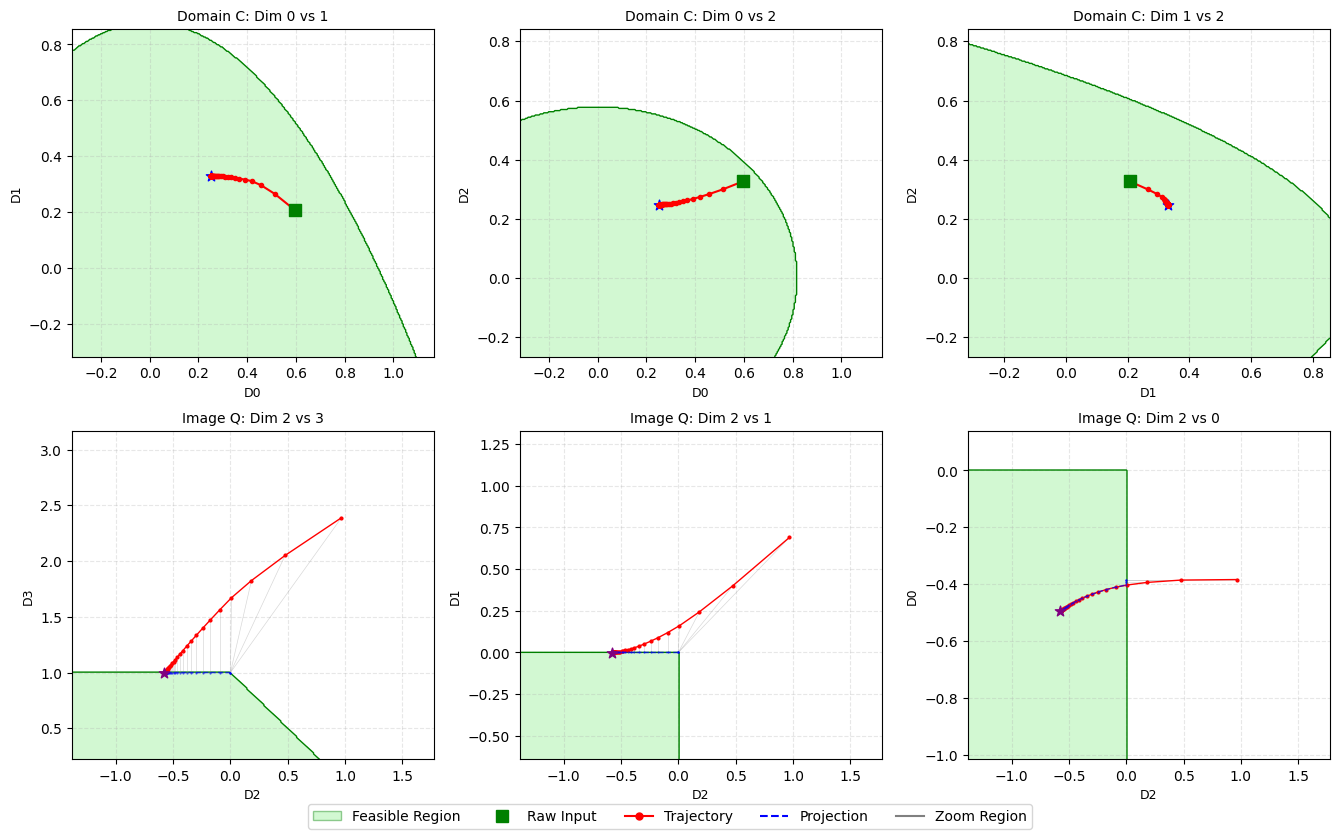

In [14]:
_ = visualize_complete_system(
    x_hist, f_hist, z_proj_hist,
    cons_C, cons_Qplus,
    x0=x0[0],   
)


# Vẽ lại luồng thuật toán

<font size=5>Tìm $x\in C$ sao cho $\exists y \in Q$ thỏa mãn $f(x) \leq y \quad(1)$ 

trong đó: 
* $C, Q$ là tập lồi, đóng
* $f$ là ánh xạ lồi

---

Định nghĩa: 

<font size=4> $Q^+ = \{z \in R^m | \exists y \in Q, z \leq y\}$

Khi đó:

<font size=4> $ (1) \Leftrightarrow $ Tìm $x \in C$ sao cho $f(x) \in Q^+$

---

Hàm khoảng cách:

$ \Phi(x) := \frac{1}{2} \rVert f(x) - P_{Q^+}(f(x)\rVert^2  $

Mục tiêu: đưa $f(x)$ về gần với hình chiếu của nó trên tập $Q^+$ nhất

* $\Phi(x) = 0 \rightarrow x$ là nghiệm chấp nhận tách
* $\Phi(x) \neq 0 \rightarrow $ chuyển về bài toán xấp xỉ tốt nhất

---


<font size=5> $\nabla \Phi (x) = J_f(x)^T (I - P_{Q^+})f(x)$

Công thức cập nhật $x^k$

<font size=5> $\Rightarrow x^{k+1} = P_C(x^k - \gamma_k \nabla\Phi(x^k))$ 

---

$P_C(\tilde x) = \text{Argmin}_{x \in C} \rVert x - \tilde x \rVert ^2$

---

$y^* = \text{Argmin}_{y \in Q} \rVert (y - \tilde z )_+\rVert ^2$

$P_{Q^+}(\tilde z) = \text{min}(\tilde z, y^*) = \tilde z - (\tilde z - y^*)_+$